# Example: Measure Indexing and Retrieval Effectiveness of Terrier, Anserini, and PISA

## Imports

In [ ]:
from datetime import timedelta
from itertools import islice
from json import loads
from pathlib import Path
from shutil import rmtree

from ir_measures import nDCG
from pandas import DataFrame, concat
from pyterrier import Experiment, Indexer, IndexRef, IterDictIndexer
from pyterrier.datasets import get_dataset
from pyterrier.terrier import Retriever
from pyterrier_anserini import AnseriniIndex, AnseriniIndexer, AnseriniRetriever
from pyterrier_pisa import PisaIndex, PisaIndexer, PisaRetrieve
from seaborn import FacetGrid, barplot, lineplot

from tirex_tracker import Measure, TrackingHandle, tracking
from tirex_tracker.pyterrier import TrackedTransformer


## Data

Load the dataset from `ir_datasets`.

In [2]:
dataset = get_dataset("irds:antique/test")

Show some documents.

In [3]:
list(islice(dataset.get_corpus_iter(), 5))

antique/test documents:   0%|          | 4/403666 [00:00<00:31, 12614.45it/s]


[{'text': "A small group of politicians believed strongly that the fact that Saddam Hussien remained in power after the first Gulf War was a signal of weakness to the rest of the world, one that invited attacks and terrorism. Shortly after taking power with George Bush in 2000 and after the attack on 9/11, they were able to use the terrorist attacks to justify war with Iraq on this basis and exaggerated threats of the development of weapons of mass destruction. The military strength of the U.S. and the brutality of Saddam's regime led them to imagine that the military and political victory would be relatively easy.",
  'docno': '2020338_0'},
 {'text': 'Because there is a lot of oil in Iraq.', 'docno': '2020338_1'},
 {'text': 'It is tempting to say that the US invaded Iraq because it has lots of oil, but the US is not a country in a deep economic problem that capturing other country’s oil is an actual need for survival. It is more likely that the Iraq invading Kuwait scenario would fall

Show the topics.

In [4]:
dataset.get_topics()

Java started (triggered by _pt_tokeniser) and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8], pyterrier_anserini.java [version=0.39.0 (from pyserini package)]


,qid,query
0,3990512,how can we get concentration onsomething
1,714612,why doesn t the water fall off earth if it s r...
2,2528767,how do i determine the charge of the iron ion ...
3,821387,i have mice how do i get rid of them humanely
4,1880028,what does see leaflet mean on ept pregnancy test
...,...,...
195,2192891,how are braces put on and do they hurt a lot
196,4406669,what do you order at taco bell
197,1582877,why do we go to school if in the real world we...
198,1340574,why do some people only go to church on easter...


Show the qrels.

In [5]:
dataset.get_qrels()

,qid,docno,label,iteration
0,1964316,1964316_5,4,U0
1,1964316,1674088_11,1,Q0
2,1964316,1218838_13,2,Q0
3,1964316,1519022_15,2,Q0
4,1964316,3059341_5,2,Q0
...,...,...,...,...
6584,1262692,247023_6,3,Q0
6585,1262692,1499030_5,3,Q0
6586,1262692,2916758_0,3,Q0
6587,1262692,1105845_15,3,Q0


## Indexing

We will consume the document iterator once to warm the document cache, so that the indexers are not slowed down by document downloads.

In [6]:
for _ in dataset.get_corpus_iter():
    pass

antique/test documents: 100%|██████████| 403666/403666 [00:00<00:00, 475175.26it/s]


### Terrier Indexing

In [7]:
terrier_index_path = Path("./index-terrier").resolve()
print(str(terrier_index_path))
if terrier_index_path.exists():
    rmtree(terrier_index_path)
terrier_indexer = IterDictIndexer(str(terrier_index_path))

with tracking() as terrier_indexing_tracking_results:
    terrier_index: IndexRef = terrier_indexer.index(dataset.get_corpus_iter()) # type: ignore


=====  Processor information  =====
Linux arch_perfmon flag  : yes
Hybrid processor         : no
IBRS and IBPB supported  : yes
STIBP supported          : yes
Spec arch caps supported : yes
Max CPUID level          : 27
CPU model number         : 140
PCM Error: can't open MSR handle for core 0 (No such file or directory)
Try no-MSR mode by setting env variable PCM_NO_MSR=1
Can not access CPUs Model Specific Registers (MSRs).
execute 'modprobe msr' as root user, then execute pcm as root user.


/home/heinrich/Repositories/tirex-tracker/python/examples/index-terrier
Give read access to /sys/class/powercap/intel-rapl/intel-rapl:1/energy_uj


antique/test documents:   0%|          | 222/403666 [00:00<04:50, 1388.53it/s]

15:19:27.112 [ForkJoinPool-1-worker-1] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index (730691_1) - further warnings are suppressed


antique/test documents: 100%|██████████| 403666/403666 [00:14<00:00, 27942.16it/s]


15:19:44.113 [ForkJoinPool-1-worker-1] WARN org.terrier.structures.indexing.Indexer -- Indexed 2224 empty documents
Give read access to /sys/class/powercap/intel-rapl/intel-rapl:1/energy_uj


### Anserini Indexing

In [8]:
anserini_index_path = Path("./index-anserini").resolve()
if anserini_index_path.exists():
    rmtree(anserini_index_path)
anserini_indexer: Indexer = AnseriniIndexer(str(anserini_index_path))

with tracking() as anserini_indexing_tracking_results:
    anserini_index: AnseriniIndex = anserini_indexer.index(dataset.get_corpus_iter())

Give read access to /sys/class/powercap/intel-rapl/intel-rapl:1/energy_uj


antique/test documents:   0%|          | 0/403666 [00:00<?, ?it/s]

2025-06-11 15:19:44,439 INFO  [main] index.SimpleIndexer (SimpleIndexer.java:138) - Using DefaultEnglishAnalyzer
2025-06-11 15:19:44,444 INFO  [main] index.SimpleIndexer (SimpleIndexer.java:139) - Stemmer: porter
2025-06-11 15:19:44,447 INFO  [main] index.SimpleIndexer (SimpleIndexer.java:140) - Keep stopwords? false
2025-06-11 15:19:44,450 INFO  [main] index.SimpleIndexer (SimpleIndexer.java:141) - Stopwords file: null


Jun 11, 2025 3:19:44 PM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false
antique/test documents: 100%|██████████| 403666/403666 [00:23<00:00, 17217.69it/s]


Give read access to /sys/class/powercap/intel-rapl/intel-rapl:1/energy_uj


### PISA Indexing

In [9]:
pisa_index_path = Path("./index-pisa").resolve()
if pisa_index_path.exists():
    rmtree(pisa_index_path)
pisa_indexer = PisaIndexer(str(pisa_index_path))
with tracking() as pisa_indexing_tracking_results:
    pisa_index: PisaIndex = pisa_indexer.index(dataset.get_corpus_iter())

Give read access to /sys/class/powercap/intel-rapl/intel-rapl:1/energy_uj


antique/test documents:  87%|████████▋ | 352490/403666 [00:03<00:01, 44007.52it/s] 

[2025-06-11 15:20:13.325] [info] [Batch 0] Processed documents [0, 100000)


antique/test documents: 100%|██████████| 403666/403666 [00:06<00:00, 59555.53it/s]

[2025-06-11 15:20:16.460] [info] [Batch 1] Processed documents [100000, 200000)


[2025-06-11 15:20:19.497] [info] [Batch 2] Processed documents [200000, 300000)
[2025-06-11 15:20:19.645] [info] [Batch 4] Processed documents [400000, 403666)
[2025-06-11 15:20:22.663] [info] [Batch 3] Processed documents [300000, 400000)
[2025-06-11 15:20:22.685] [info] Merging titles
[2025-06-11 15:20:22.687] [info] Creating document lexicon
[2025-06-11 15:20:22.717] [info] Merging URLs
[2025-06-11 15:20:22.718] [info] Collecting terms
[2025-06-11 15:20:22.807] [info] Writing terms
[2025-06-11 15:20:22.825] [info] Mapping terms
[2025-06-11 15:20:22.850] [info] Remapping IDs
[2025-06-11 15:20:23.036] [info] Concatenating batches
[2025-06-11 15:20:23.097] [info] Success.
[2025-06-11 15:20:23.108] [info] Inverting [0, 100000)
[2025-06-11 15:20:23.576] [info] Inverting [100000, 200000)
[2025-06-11 15:20:24.067] [info] Inverting [200000, 300000)
[2025-06-11 15:20:24.623] [info] Inverting [300000, 400000)
[2025-06-11 15:20:25.172] [info] Inverting [400000, 403666)
[2025-06-11 15:20:25.296

### Results

In [17]:
def tracking_results_to_df(
    tracking_results: TrackingHandle, measure: Measure
) -> DataFrame:
    measure_results = tracking_results[measure]
    measure_value = loads(measure_results.value)
    df = (
        DataFrame(measure_value["timeseries"])
        .rename(
            columns={
                "timestamps": "timestamp",
                "values": "value",
            }
        )
        .assign(
            measure=measure.name,
            max_value=measure_value["max"],
            min_value=measure_value["min"],
        )
    )
    df["timestamp"] = df["timestamp"].astype("timedelta64[ms]")
    return df

In [18]:
df_indexing = concat([
    tracking_results_to_df(tracking_results, measure).assign(name=name)
    for name, tracking_results in [
        ("Terrier", terrier_indexing_tracking_results),
        ("Anserini", anserini_indexing_tracking_results),
        ("PISA", pisa_indexing_tracking_results),
    ]
    for measure in [
        Measure.CPU_USED_PROCESS_PERCENT,
        Measure.CPU_USED_SYSTEM_PERCENT,
        Measure.RAM_USED_PROCESS_KB,
        Measure.RAM_USED_SYSTEM_MB,
    ]
])
df_indexing

,timestamp,value,measure,max_value,min_value,name
0,0 days 00:00:00,0,CPU_USED_PROCESS_PERCENT,254,0,Terrier
1,0 days 00:00:00.100000,150,CPU_USED_PROCESS_PERCENT,254,0,Terrier
2,0 days 00:00:00.200000,54,CPU_USED_PROCESS_PERCENT,254,0,Terrier
3,0 days 00:00:00.301000,204,CPU_USED_PROCESS_PERCENT,254,0,Terrier
4,0 days 00:00:00.401000,184,CPU_USED_PROCESS_PERCENT,254,0,Terrier
...,...,...,...,...,...,...
151,0 days 00:00:15.136000,31547,RAM_USED_SYSTEM_MB,31569,0,PISA
152,0 days 00:00:15.236000,31560,RAM_USED_SYSTEM_MB,31569,0,PISA
153,0 days 00:00:15.336000,31569,RAM_USED_SYSTEM_MB,31569,0,PISA
154,0 days 00:00:15.436000,31548,RAM_USED_SYSTEM_MB,31569,0,PISA


## Retrieval

Create the BM25 retrievers for Terrier, Anserini, and PISA. Then wrap the retrievers with `TrackedTransformer` to track their execution.

In [19]:
terrier_bm25 = TrackedTransformer(Retriever(terrier_index, wmodel="BM25"))
anserini_bm25: AnseriniRetriever = TrackedTransformer(anserini_index.bm25())
pisa_bm25: PisaRetrieve = TrackedTransformer(pisa_index.bm25())

## Experiment

In [20]:
results = Experiment(
    retr_systems=[
        terrier_bm25,
        anserini_bm25,
        pisa_bm25,
    ],
    topics=dataset.get_topics()[:3],
    qrels=dataset.get_qrels(),
    eval_metrics=[nDCG @ 10, nDCG @ 5],
    names=[
        "Terrier BM25",
        "Anserini BM25",
        "PISA BM25",
    ],
    perquery=True,
)
results

Give read access to /sys/class/powercap/intel-rapl/intel-rapl:1/energy_uj
Give read access to /sys/class/powercap/intel-rapl/intel-rapl:1/energy_uj
Give read access to /sys/class/powercap/intel-rapl/intel-rapl:1/energy_uj
Give read access to /sys/class/powercap/intel-rapl/intel-rapl:1/energy_uj
Give read access to /sys/class/powercap/intel-rapl/intel-rapl:1/energy_uj
Give read access to /sys/class/powercap/intel-rapl/intel-rapl:1/energy_uj


,name,qid,measure,value
10,Anserini BM25,2528767,nDCG@5,0.946503
11,Anserini BM25,2528767,nDCG@10,0.805926
6,Anserini BM25,3990512,nDCG@5,0.000000
7,Anserini BM25,3990512,nDCG@10,0.041172
8,Anserini BM25,714612,nDCG@5,0.508740
9,Anserini BM25,714612,nDCG@10,0.412978
16,PISA BM25,2528767,nDCG@5,0.868795
17,PISA BM25,2528767,nDCG@10,0.763464
12,PISA BM25,3990512,nDCG@5,0.067827
13,PISA BM25,3990512,nDCG@10,0.065634


In [22]:
df_retrieval = concat([
    tracking_results_to_df(tracking_results, measure).assign(name=name)
    for name, tracking_results in [
        ("Terrier BM25", terrier_bm25.results),
        ("Anserini BM25", anserini_bm25.results),
        ("PISA BM25", pisa_bm25.results),
    ]
    for measure in [
        Measure.CPU_USED_PROCESS_PERCENT,
        Measure.CPU_USED_SYSTEM_PERCENT,
        Measure.RAM_USED_PROCESS_KB,
        Measure.RAM_USED_SYSTEM_MB,
    ]
])
df_retrieval

,timestamp,value,measure,max_value,min_value,name
0,0 days 00:00:00,0,CPU_USED_PROCESS_PERCENT,200,0,Terrier BM25
1,0 days 00:00:00.101000,200,CPU_USED_PROCESS_PERCENT,200,0,Terrier BM25
0,0 days 00:00:00,100,CPU_USED_SYSTEM_PERCENT,100,0,Terrier BM25
1,0 days 00:00:00.101000,57,CPU_USED_SYSTEM_PERCENT,100,0,Terrier BM25
0,0 days 00:00:00,1729380,RAM_USED_PROCESS_KB,1729642,0,Terrier BM25
1,0 days 00:00:00.101000,1729642,RAM_USED_PROCESS_KB,1729642,0,Terrier BM25
0,0 days 00:00:00,32388,RAM_USED_SYSTEM_MB,32398,0,Terrier BM25
1,0 days 00:00:00.101000,32398,RAM_USED_SYSTEM_MB,32398,0,Terrier BM25
0,0 days 00:00:00,0,CPU_USED_PROCESS_PERCENT,64,0,Anserini BM25
1,0 days 00:00:00.100000,64,CPU_USED_PROCESS_PERCENT,64,0,Anserini BM25


## Results

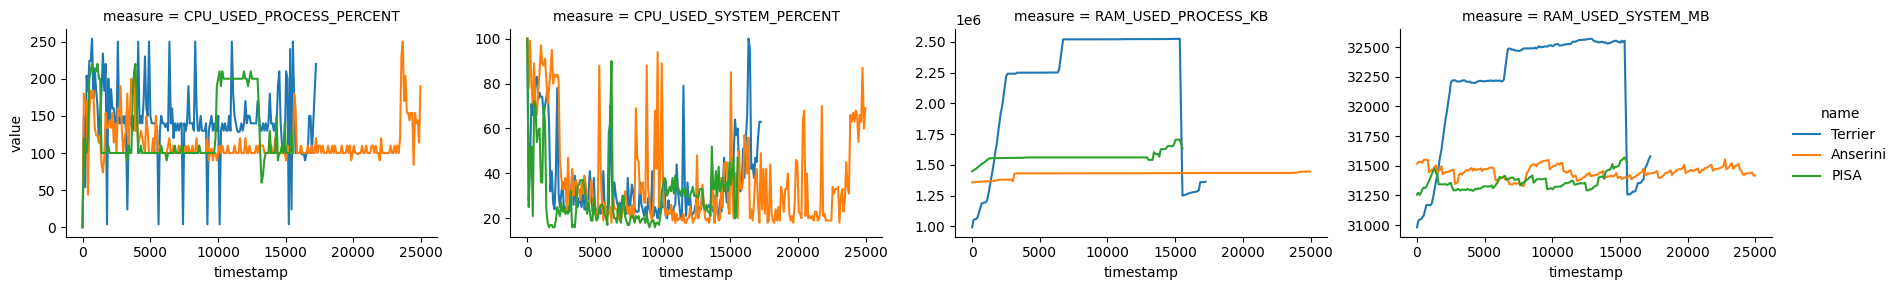

In [25]:
plot = FacetGrid(
    df_indexing,
    col="measure",
    hue="name",
    sharey=False,
    sharex=False,
    height=3,
    aspect=1.5,
)
plot.map_dataframe(
    lineplot,
    x="timestamp",
    y="value",
)
plot.add_legend()
plot

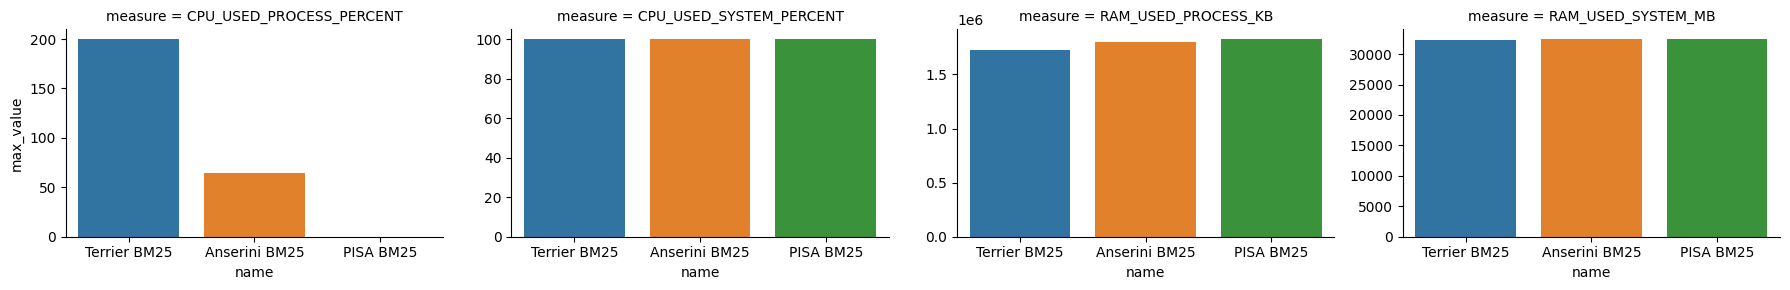

In [26]:
plot = FacetGrid(
    df_retrieval[df_retrieval["timestamp"] <= timedelta()],
    col="measure",
    hue="name",
    sharey=False,
    sharex=False,
    height=3,
    aspect=1.5,
)
plot.map_dataframe(
    barplot,
    x="name",
    y="max_value",
    dodge=True,
)
# plot.set(yscale="log")
plot